In [1]:
import sys
sys.path.insert(0, '/home/swryu/jylee/generativeODE/disentangled_ODE/')

from models.NeuralProcess import ConditionalFNP

In [2]:
from datasets.cond_dataset import get_dataloader
import torch

import os
import numpy as np
import matplotlib.pyplot as plt
import time
import easydict

In [3]:
# load model
# load Transformer_sin_recon_all
args = easydict.EasyDict({'data_length': 500,
                         'dataset_path': '/home/swryu/jylee/data/input/',
                         'dataset_type': 'sin',
                         'dropout': 0.1,
                         'encoder': 'Transformer',
                         'encoder_attnheads': 1,
                         'encoder_blocks': 2,
                         'encoder_embedding_dim': 128,
                         'encoder_hidden_dim': 128,
                         'expfunc': 'fourier',
                         'in_features': 1,
                         'latent_dimension': 64,
                         'lower_bound': 1,
                         'model_type': 'FNP',
                         'n_eig': 2,
                         'n_harmonics': 8,
                         'num_label': 4,
                         'out_features': 1,
                         'test_model': 'NP',
                         'upper_bound': 8,
                         'batch_size': 512})

# for large model
# args = easydict.EasyDict({'data_length': 500,
#                          'dataset_path': '/home/swryu/jylee/data/input/',
#                          'dataset_type': 'sin',
#                          'dropout': 0.1,
#                          'encoder': 'Transformer',
#                          'encoder_attnheads': 1,
#                          'encoder_blocks': 2,
#                          'encoder_embedding_dim': 128,
#                          'encoder_hidden_dim': 256,
#                          'expfunc': 'fourier',
#                          'in_features': 1,
#                          'latent_dimension':128,
#                          'lower_bound': 1,
#                          'model_type': 'FNP',
#                          'n_eig': 2,
#                          'n_harmonics': 8,
#                          'num_label': 4,
#                          'out_features': 1,
#                          'test_model': 'NP',
#                          'upper_bound': 8,
#                          'batch_size': 512})


model = ConditionalFNP(args).cuda()

In [4]:
# load parameter
path = '/home/swryu/jylee/data/output/0619/sinTransformer_FNP_sin_fulldecoded.pt'
#path = '/home/swryu/jylee/data/output/0619/sinTransformer_FNP_sin_fulldecoded_big.pt'

ckpt = torch.load(path)
model.load_state_dict(ckpt['model_state_dict'])
loss = ckpt['loss']

In [5]:
loss

0.6172749400138855

In [6]:
# test on test dataset
model.eval()
test_dataloader = get_dataloader(args, 'test')

avg_test_loss = 0.
avg_test_mse = 0.
avg_kl = 0.

with torch.no_grad():
    for iter, sample in enumerate(test_dataloader):
        samp_sin = sample['sin'].cuda()
        freq = sample['freq']
        amp = sample['amp']
        label = sample['label'].cuda()
        orig_ts = sample['orig_ts'].cuda()
        
        mse_loss, kl_loss = model(orig_ts, samp_sin, label, sampling=False)
        loss = mse_loss + kl_loss
        avg_test_loss += (loss.item() / len(test_dataloader))
        avg_test_mse += (mse_loss.item() / len(test_dataloader))
        avg_kl += (kl_loss.item() / len(test_dataloader))
        

In [7]:
print(f'Test MSE: {avg_test_mse:.3f}')
print(f'Test kl: {avg_kl:.3f}')

Test MSE: 0.527
Test kl: 0.102


In [8]:
# plot reconstruction and generation
def sin_result_plot(samp_sin, orig_ts, freq, amp, label):
    model.eval()

    # reconstruction
    samp_sin = samp_sin.unsqueeze(0)
    orig_ts = orig_ts.unsqueeze(0)
    test_tss = torch.Tensor(np.linspace(0, 5, 400)).to(samp_sin.device)   # (1, 1, S)
    with torch.no_grad():
        decoded_traj = model.predict(orig_ts, samp_sin, label.unsqueeze(0), test_tss.unsqueeze(0))

    test_ts = test_tss.cpu().numpy()
    orig_sin = amp[0] * np.sin(freq[0] * test_ts* 2 * np.pi) + amp[1] * np.sin(freq[1] * test_ts * 2 * np.pi) + amp[2] * np.sin(freq[2]*test_ts*2*np.pi) +\
        amp[3]*np.cos(freq[3]*test_ts*2*np.pi) + amp[4]*np.cos(freq[4]*test_ts*2*np.pi) + amp[5]*np.cos(freq[5]*test_ts*2*np.pi)

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(test_ts, orig_sin.cpu().numpy(), 'g', label='true trajectory')
    ax.scatter(orig_ts.cpu().numpy(), samp_sin[0].squeeze(-1).cpu().numpy(), s=5, label='sampled points')
    ax.plot(test_ts, decoded_traj.squeeze().detach().cpu().numpy(), 'r', label='learned trajectory')
    plt.legend()
    plt.show()

    # inference - random sampling
    generated_traj = model.inference(test_tss.unsqueeze(0), label)
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(test_ts, generated_traj.squeeze().detach().cpu().numpy(), 'g', label='inference')
    if label == 0:
        str_label = 'low amplitude, low frequency'
    elif label == 1:
        str_label = 'low amplitude, high frequency'
    elif label == 2:
        str_label = 'high amplitude, low frequency'
    elif label == 3:
        str_label = 'high amplitude, high frequency'
    
    print(model.decoder.coeffs)
    
    plt.title(str_label)
    plt.legend()
    plt.show()

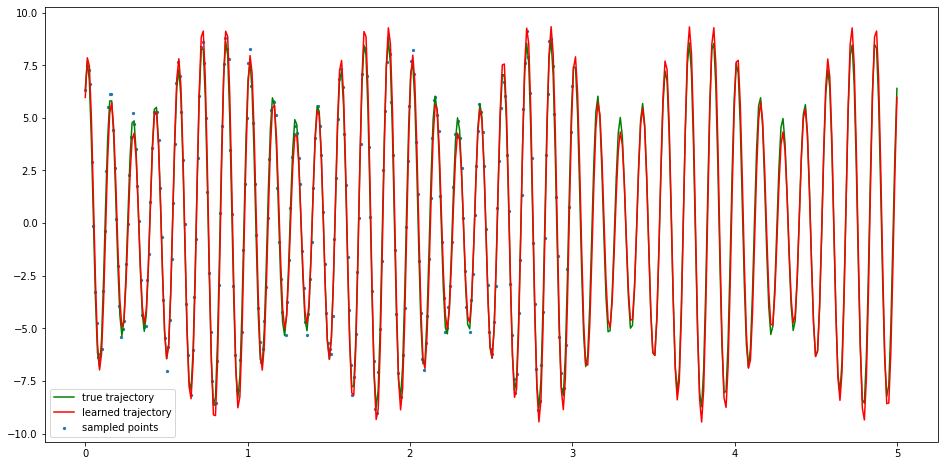

tensor([[-1.7178e+00,  1.0554e+01, -9.3449e-03,  3.5482e-03,  3.6868e-03,
          1.6339e+00,  1.0178e+01, -1.8302e-02,  1.3975e+00,  2.6672e+00,
          4.7586e-02, -2.2820e-02,  1.6882e-02,  5.2059e+00,  9.8502e+00,
          1.3978e-03]], device='cuda:0')


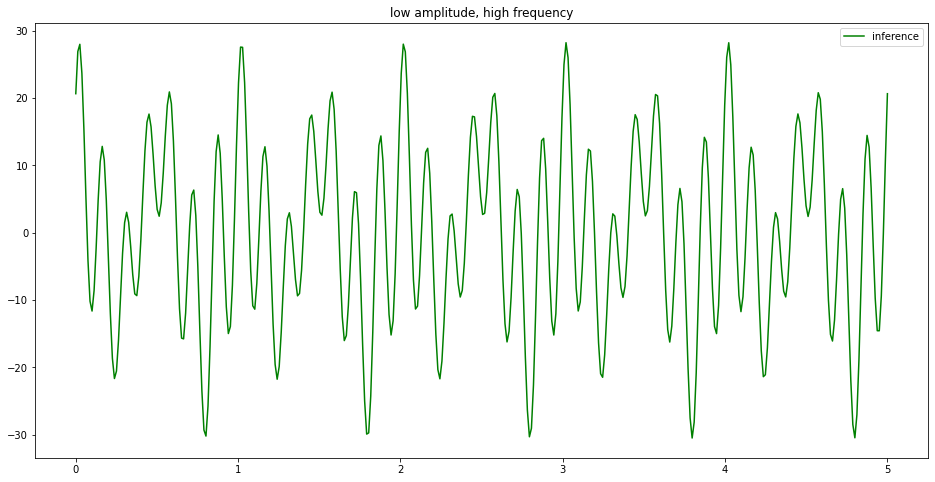

-1.72, 10.55, -0.01, 0.00, 0.00, 1.63, 10.18, -0.02

1.40, 2.67, 0.05, -0.02, 0.02, 5.21, 9.85, 0.00


In [9]:
i = 3
sin_result_plot(samp_sin[i], orig_ts[i], freq[i], amp[i], label[i])

print(', '.join('{:.2f}'.format(f) for f in model.decoder.coeffs[:, :8].tolist()[0]))
print('')
print(', '.join('{:.2f}'.format(f) for f in model.decoder.coeffs[:, 8:].tolist()[0]))

In [27]:
print(model.decoder.coeffs[:, :8].tolist())
print('')
print(model.decoder.coeffs[:, 8:].tolist())

[[9.298102378845215, 4.453142166137695, 0.015496687963604927, 0.010426703840494156, 0.00649928767234087, -4.4962477684021, 7.250600814819336, 0.03501107543706894]]

[[0.28168803453445435, -0.3597508668899536, 0.0015908771893009543, 0.05717913806438446, -0.0017014270415529609, 4.145359039306641, -3.3375699520111084, 0.024052714928984642]]


In [31]:
model.decoder.coeffs[:, :8].tolist()[0]

[3.075751781463623,
 13.91451358795166,
 -0.0034549073316156864,
 -0.014869016595184803,
 0.00642008613795042,
 0.62663733959198,
 1.8794769048690796,
 -0.007813911885023117]

In [ ]:
sin_gen_plot(samp_sin[i], orig_ts[i], freq[i], amp[i], label[i])